In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import copy

### Load Dataset

In [2]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("./datas/bike_data.csv").drop(["Date", "Holiday", "Seasons"], axis=1)
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)

# Only concider data at 12 pm
df = df[df["hour"] == 12]
df = df.drop(["hour", "wind", "visibility", "functional"], axis=1)
df.head(5)

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


In [3]:
from sklearn.model_selection import train_test_split

x = df[df.columns[1:]].values
y = df[df.columns[0]].values.reshape(-1,1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=True)

x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)

y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

x_train.shape, y_train.shape

(torch.Size([244, 6]), torch.Size([244, 1]))

### Build Training Model

In [4]:
class Model(torch.nn.Module):
    def __init__(self, input=6, h1=32, h2=32, h3=32, output=1):
        super().__init__()
        self.layer1 = torch.nn.Linear(input, h1)
        self.layer2 = torch.nn.Linear(h1, h2)
        self.layer3 = torch.nn.Linear(h2, h3)
        self.output = torch.nn.Linear(h2, output)

    def forward(self, x):
        x = torch.nn.functional.relu(self.layer1(x))
        x = torch.nn.functional.relu(self.layer2(x))
        x = torch.nn.functional.relu(self.layer3(x))
        x = self.output(x)

        return x

In [5]:
model = Model()

# Set Loss Function
criterion = torch.nn.MSELoss()

# Set Optimizeer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

### Training The Model

In [6]:
epochs = 100
losses = []

for i in range(epochs):
    # Predict the value
    y_pred = model.forward(x_train)

    # Added the loss value
    loss = criterion(y_pred, y_train)
    losses.append(loss.detach().numpy)

    # Back Propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print(f"Final Epoch: {i+1} and Loss Value: {loss}")

Final Epoch: 100 and Loss Value: 84979.515625


### Plot The Result

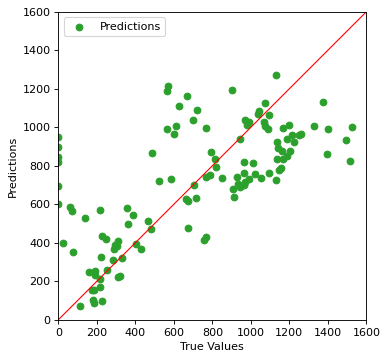

In [7]:
with torch.no_grad():
    y_pred = model.forward(x_test)

plt.figure(figsize = (8,5), dpi = 80)
ax = plt.axes(aspect="equal")
plt.scatter(y_test, y_pred, label="Predictions", c="#2CA02C")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 1600]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
plt.plot(lims, lims, c="red", linewidth=1)